In [1]:
import os
os.chdir('../../stylegan2-ada-pytorch')

In [2]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.utils import io
import PIL.Image
from tqdm import tqdm
from glob import glob

# Imports for the projection function
import dnnlib
import legacy
from time import perf_counter
from projector import project

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'

print(f"Using {DEVICE} as device")

Using mps as device


### Import Model

In [4]:
# Load model architecture
experiment_path = "../../Data.nosync/Models/Stylegan2_Ada/Experiments/00002-stylegan2_ada_images-mirror-auto2-kimg1000-resumeffhq512/"
model_name = "network-snapshot-000920.pkl"
model_path = experiment_path + model_name
with open(model_path, 'rb') as f:
    architecture = pickle.load(f)
    G = architecture['G_ema'].to(DEVICE)  # torch.nn.Module 
    D = architecture['D'].to(DEVICE)

### Test Random Generation

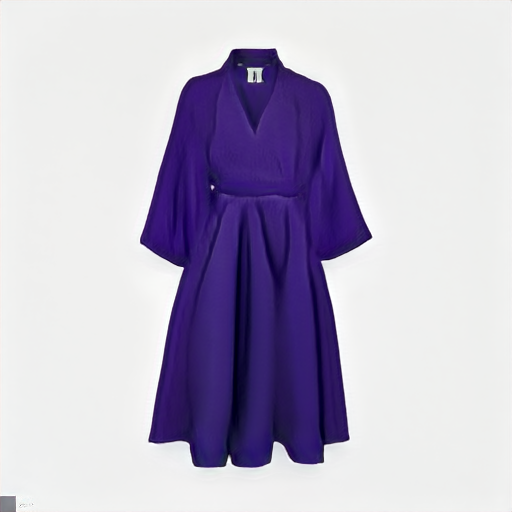

In [10]:
z = torch.randn([1, G.z_dim]).to(DEVICE)    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c,  force_fp32=True) 

img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB')

### Test Interpolation

In [6]:
def get_interpolations(seed1, seed2, num_intermediates = 10):
    torch.manual_seed(seed1)
    z1 = torch.randn([1, G.z_dim]).to(DEVICE)
    w1 = G.mapping(z1, c)
    torch.manual_seed(seed2)
    z2 = torch.randn([1, G.z_dim]).to(DEVICE)
    w2 = G.mapping(z2, c)

    # Linearly interpolate between w1 and w2
    interpolated_tensors = []
    for i in range(num_intermediates + 2):  # including w1 and w2
        alpha = i / (num_intermediates + 1)
        interpolated_tensor = torch.lerp(w1, w2, alpha)
        interpolated_tensors.append(interpolated_tensor)

    # Generate images
    imgs = []
    for tensor in tqdm(interpolated_tensors, desc='Generating images'):
        img = G.synthesis(tensor, noise_mode='const')
        img_perm = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        imgs.append(PIL.Image.fromarray(img_perm[0].cpu().numpy(), 'RGB'))
    
    return imgs

In [11]:
seed1 = 9082
seed2 = 3454689
num_intermediates = 10

imgs = get_interpolations(seed1, seed2, num_intermediates=num_intermediates)

def show_image(idx):
    plt.figure(figsize=(8, 8))
    plt.imshow(imgs[idx])
    plt.axis('off')
    plt.show()

num_images = len(imgs)
interact(show_image, idx=IntSlider(min=0, max=num_images-1, step=1, value=0))
plt.show()

Generating images: 100%|██████████| 12/12 [00:02<00:00,  4.56it/s]


interactive(children=(IntSlider(value=0, description='idx', max=11), Output()), _dom_classes=('widget-interact…

### Test Reconstruction

1. Choose random original image
2. Project image into w-space
3. Generate new image from w-space
4. Compare original and generated image

In [8]:
def run_projection(
    network_pkl: str,
    target_fname: str,
    seed:int = 42,
    num_steps:int = 1000, 
    silent = True):
    
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Load networks.
    print('Loading networks from "%s"...' % network_pkl)
    device = torch.device('cuda')
    with dnnlib.util.open_url(network_pkl) as fp:
        G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

    # Load target image.
    target_pil = PIL.Image.open(target_fname).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    target_uint8 = np.array(target_pil, dtype=np.uint8)

    # Optimize projection.
    start_time = perf_counter()
    projected_w_steps = project(
        G,
        target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device), # pylint: disable=not-callable
        num_steps=num_steps,
        device=device,
        verbose=True
    )
    print (f'Elapsed: {(perf_counter()-start_time):.1f} s')

    # Save final projected frame and W vector.
    projected_w = projected_w_steps[-1]
    synth_image = G.synthesis(projected_w.unsqueeze(0), noise_mode='const')
    synth_image_perm = (synth_image.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    synth_image = PIL.Image.fromarray(synth_image_perm[0].cpu().numpy(), 'RGB')

    
    return (projected_w, target_pil, synth_image)

In [13]:
NUM_EXAMPLES = 5
NUM_STEPS = 500

orig_images = glob('../../Data.nosync/Zalando_Dataset/dresses/images/stylegan2_ada_images/*/*.png')
network = model_path


reconstructed_imgs = []
for i in tqdm(range(NUM_EXAMPLES)):
    np.random.seed()
    orig_path = np.random.choice(orig_images)
    with io.capture_output() as captured:
        projected_w, target_pil, synth_image = run_projection(network_pkl=model_path, target_fname=orig_path, num_steps=NUM_STEPS);
    reconstructed_imgs.append((projected_w, target_pil, synth_image))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:33<00:00, 30.79s/it]


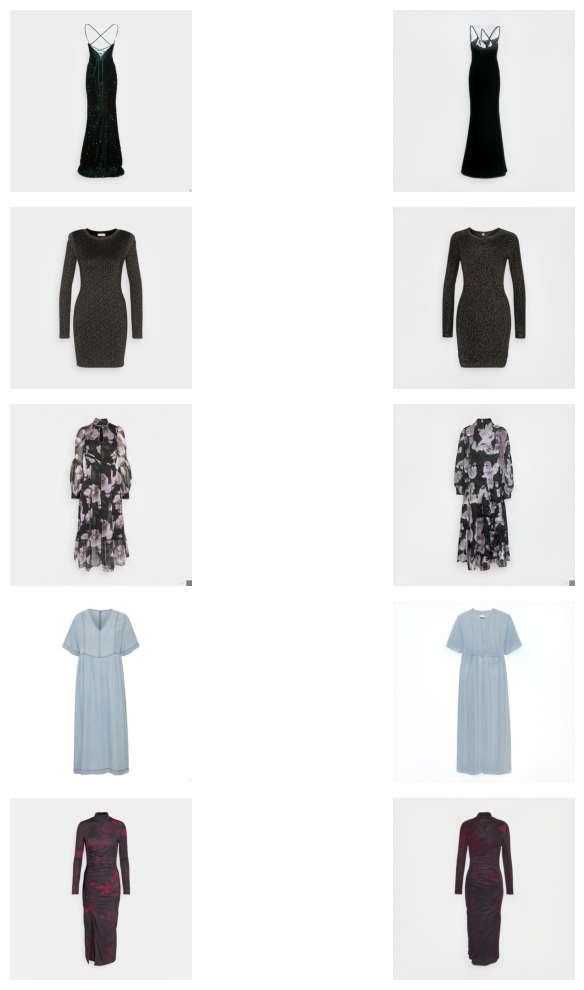

In [14]:
# Plot the images
fig, axs = plt.subplots(NUM_EXAMPLES, 2, figsize=(10, 10))
for i, (_, orig_img, projected_img) in enumerate(reconstructed_imgs):
    axs[i, 0].imshow(orig_img)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(projected_img)
    axs[i, 1].axis('off')
fig.tight_layout()